In [3]:
!pip install wfdb
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 115.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [4]:
# Importar bibliotecas
import pandas as pd
import numpy as np
import wfdb
import ast
import os
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from collections import Counter

In [5]:
# Crear directorio para los datos
!mkdir -p /content/ptbxl

In [6]:
# Descargar archivos de metadatos desde PhysioNet
!wget -P /content/ptbxl https://physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv
!wget -P /content/ptbxl https://physionet.org/files/ptb-xl/1.0.3/scp_statements.csv

--2025-04-29 17:34:32--  https://physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6594879 (6.3M) [text/plain]
Saving to: ‘/content/ptbxl/ptbxl_database.csv’

ptbxl_database.csv  100%[===================>]   6.29M   295KB/s    in 22s     

2025-04-29 17:34:54 (293 KB/s) - ‘/content/ptbxl/ptbxl_database.csv’ saved [6594879/6594879]

--2025-04-29 17:34:54--  https://physionet.org/files/ptb-xl/1.0.3/scp_statements.csv
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9720 (9.5K) [text/plain]
Saving to: ‘/content/ptbxl/scp_statements.csv’

scp_statements.csv  100%[===================>]   9.49K  --.-KB/s    in 0s      

2025-04-29 17:34:55 (316 MB/s) - ‘/content/ptbxl/scp_st

In [7]:
# Descargar una muestra de datos ECG (records100/)
# !wget -r -N -c -np -P /content/ptbxl https://physionet.org/files/ptb-xl/1.0.3/records100/00000/
#!rm -rf /content/ptbxl/records100/
!wget -r -N -c -np -P /content/ptbxl https://physionet.org/files/ptb-xl/1.0.3/records100

Se han truncado las últimas 5000 líneas del flujo de salida.
Saving to: ‘/content/ptbxl/physionet.org/files/ptb-xl/1.0.3/records100/01000/01422_lr.dat’

physionet.org/files 100%[===================>]  23.44K  --.-KB/s    in 0.02s   

2025-04-29 17:42:04 (1.20 MB/s) - ‘/content/ptbxl/physionet.org/files/ptb-xl/1.0.3/records100/01000/01422_lr.dat’ saved [24000/24000]

--2025-04-29 17:42:04--  https://physionet.org/files/ptb-xl/1.0.3/records100/01000/01422_lr.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 604 [text/plain]
Saving to: ‘/content/ptbxl/physionet.org/files/ptb-xl/1.0.3/records100/01000/01422_lr.hea’

physionet.org/files 100%[===================>]     604  --.-KB/s    in 0s      

2025-04-29 17:42:04 (377 MB/s) - ‘/content/ptbxl/physionet.org/files/ptb-xl/1.0.3/records100/01000/01422_lr.hea’ saved [604/604]

--2025-04-29 17:42:04--  https://physionet.org/files/ptb-xl/1.0.3/records100/01000/01423_lr.dat
Reusing existi

In [ ]:
# Establecer ruta al directorio de datos
path = '/content/ptbxl/'

In [ ]:
# Cargar metadatos desde ptbxl_database.csv
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

In [ ]:
# Cargar scp_statements.csv para agregación diagnóstica
agg_df = pd.read_csv(path + 'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [ ]:
# Crear columna con superclases diagnósticas
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [ ]:
# Función para cargar datos crudos de señales ECG
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = []
        for f in df.filename_lr:
            file_path = path + f
            if os.path.exists(file_path + '.hea'):
                signal, _ = wfdb.rdsamp(file_path)
                data.append(signal)
            else:
                print(f"Archivo no encontrado: {file_path}")
        data = np.array(data)
    else:
        data = [wfdb.rdsamp(path + f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
    return data

In [ ]:
# Cargar datos a 100 Hz (baja resolución para menor uso de memoria)
sampling_rate = 100
X = load_raw_data(Y, sampling_rate, path)

In [ ]:
# Dividir en conjuntos de entrenamiento y prueba usando strat_fold
test_fold = 10
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[Y.strat_fold != test_fold].diagnostic_superclass
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

In [ ]:
# Codificar etiquetas para clasificación multietiqueta
all_superclasses = set()
for sc in y_train:
    all_superclasses.update(sc)
for sc in y_test:
    all_superclasses.update(sc)
all_superclasses = list(all_superclasses)
number_of_classes = len(all_superclasses)

mlb = MultiLabelBinarizer(classes=all_superclasses)
y_train_encoded = mlb.fit_transform(y_train)
y_test_encoded = mlb.transform(y_test)

In [ ]:
# Definir modelo híbrido LSTM-CNN
model = Sequential()
model.add(Input(shape=(1000, 12)))
model.add(Conv1D(32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(LSTM(64))
model.add(Dense(number_of_classes, activation='sigmoid'))

In [ ]:
# Compilar modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Entrenar modelo (habilite GPU para acelerar)
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded))

Epoch 1/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 144s 228ms/step - accuracy: 0.4563 - loss: 0.5162 - val_accuracy: 0.1652 - val_loss: 0.7425
Epoch 2/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 139s 228ms/step - accuracy: 0.4268 - loss: 0.4928 - val_accuracy: 0.5773 - val_loss: 0.4184
Epoch 3/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 128s 210ms/step - accuracy: 0.5611 - loss: 0.3975 - val_accuracy: 0.5778 - val_loss: 0.3884
Epoch 4/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 140s 206ms/step - accuracy: 0.5981 - loss: 0.3649 - val_accuracy: 0.5928 - val_loss: 0.3565
Epoch 5/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 127s 207ms/step - accuracy: 0.6312 - loss: 0.3344 - val_accuracy: 0.6306 - val_loss: 0.3564
Epoch 6/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 126s 206ms/step - accuracy: 0.6479 - loss: 0.3176 - val_accuracy: 0.6256 - val_loss: 0.3419
Epoch 7/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 128s 208ms/step - accuracy: 0.6599 - loss: 0.3035 - val_accuracy: 0.6110 - val_loss: 0.3266
Epoch 8/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 127s 207ms/step - accuracy: 0.6647 -

In [ ]:
# Evaluar modelo
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step


In [ ]:
print("Reporte de clasificación:")
print(classification_report(y_test_encoded, y_pred_binary, target_names=mlb.classes_))

Reporte de clasificación:
              precision    recall  f1-score   support

          MI       0.77      0.59      0.67       550
          CD       0.76      0.61      0.68       496
        NORM       0.78      0.89      0.83       963
         HYP       0.77      0.34      0.47       262
        STTC       0.79      0.64      0.71       521

   micro avg       0.78      0.68      0.73      2792
   macro avg       0.78      0.61      0.67      2792
weighted avg       0.78      0.68      0.72      2792
 samples avg       0.73      0.70      0.70      2792



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Matrices de confusión por clase
for i, class_name in enumerate(mlb.classes_):
    print(f"Matriz de confusión para {class_name}:")
    print(confusion_matrix(y_test_encoded[:, i], y_pred_binary[:, i]))

Matriz de confusión para MI:
[[1554   94]
 [ 227  323]]
Matriz de confusión para CD:
[[1608   94]
 [ 192  304]]
Matriz de confusión para NORM:
[[997 238]
 [107 856]]
Matriz de confusión para HYP:
[[1910   26]
 [ 173   89]]
Matriz de confusión para STTC:
[[1589   88]
 [ 186  335]]


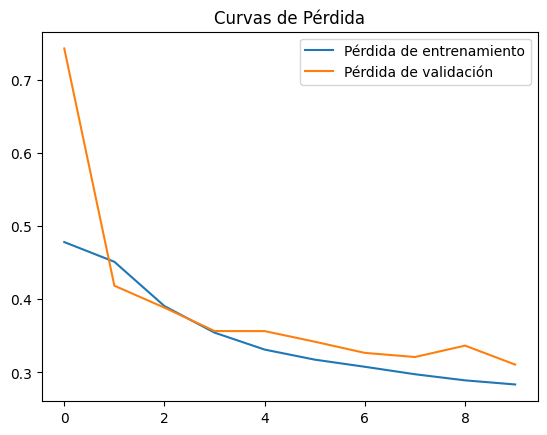

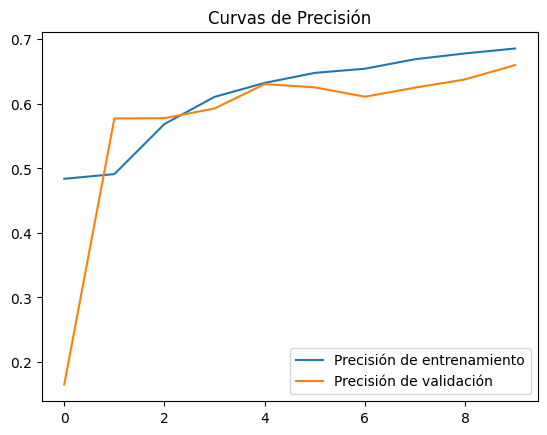

In [ ]:
# Graficar historial de entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.legend()
plt.title('Curvas de Pérdida')
plt.show()

plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.legend()
plt.title('Curvas de Precisión')
plt.show()

In [ ]:
# Estadísticas del conjunto de datos
print("Número total de registros:", len(Y))
print("Número de registros de entrenamiento:", len(X_train))
print("Número de registros de prueba:", len(X_test))
print("Superclases diagnósticas:", all_superclasses)

superclass_counts = Counter()
for sc in Y.diagnostic_superclass:
    superclass_counts.update(sc)
print("Frecuencia de superclases:", superclass_counts)

Número total de registros: 21799
Número de registros de entrenamiento: 19601
Número de registros de prueba: 2198
Superclases diagnósticas: ['MI', 'CD', 'NORM', 'HYP', 'STTC']
Frecuencia de superclases: Counter({'NORM': 9514, 'MI': 5469, 'STTC': 5235, 'CD': 4898, 'HYP': 2649})


In [ ]:
# Guardar el modelo en formato HDF5 y descargarlo localmente

model.save('/content/model_lstm_cnn_ptbxl.h5')
print("Modelo guardado como model_lstm_cnn_ptbxl.h5")

Modelo guardado como model_lstm_cnn_ptbxl.h5
